In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

## Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

# ## Find Bloop
# bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
# bloop_cut = []
# for i in range(len(smc)):
#     if i not in np.squeeze(bloop).tolist():
#         bloop_cut.append(i)
        
# smc_nobloop = smc[bloop_cut]

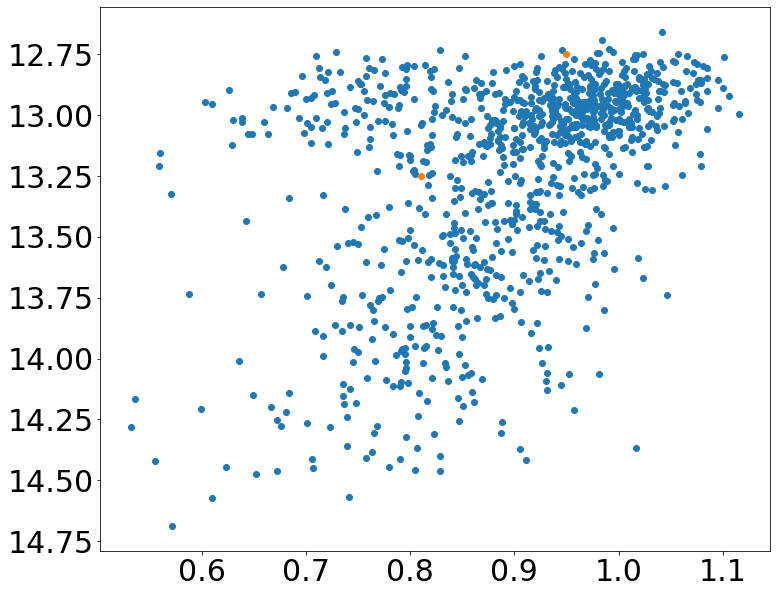

In [3]:
plt.figure(figsize=[12,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.scatter(0.81,13.25,c='tab:orange')
plt.scatter(0.95,12.75,c='tab:orange')
plt.gca().invert_yaxis()

 
-3.571 x + 16.14


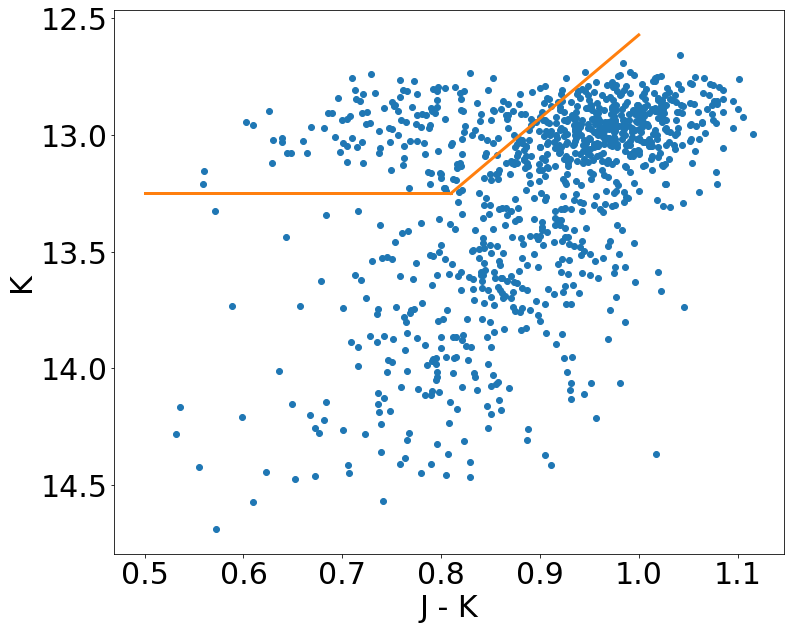

In [4]:
zbloop = np.polyfit([0.81,0.95], [13.25,12.75], 1)
pbloop = np.poly1d(zbloop)

print(pbloop)

plt.figure(figsize=[12,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.plot([0.81,1.0],[pbloop(0.81),pbloop(1.0)],c='tab:orange',lw=3.)
plt.plot([0.5,0.81],[13.25,13.25],c='tab:orange',lw=3.)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

In [5]:
def bloop(j_k):
    '''
    Function used to cut the bloop using apparent 2Mass colors. The return is the K on the boundary as a function
    of J - K color.
    
    Inputs:
    ------
    j_k: J - K 2Mass color
    
    Outputs:
    -------
    k: apparent 2Mass K of bloop cut 
    '''
    
    if j_k <= 0.81:
        return 13.25 #k
    else:
        return -3.571*j_k + 16.14
            

In [6]:
j_kcols = smc['J']-smc['K']

bloop_idx = []
for i in range(len(j_kcols)):
    if smc['K'][i] < bloop(j_kcols[i]):
        bloop_idx.append(int(i))

bloop_cut = []
for i in range(len(smc)):
    if i not in bloop_idx:
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

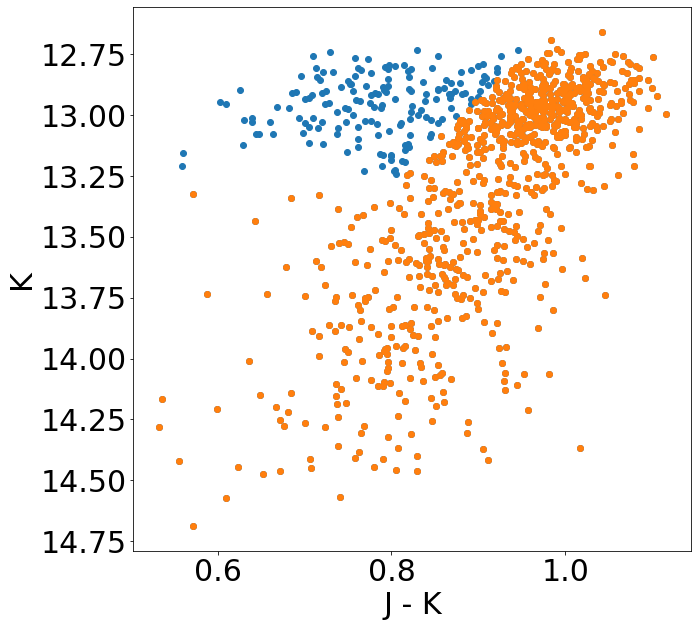

In [7]:
plt.figure(figsize=[10,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.scatter((smc_nobloop['J']-smc_nobloop['K']),smc_nobloop['K'])

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')

plt.show()

In [8]:
################################
### Individual APOGEE Fields ###
################################

# tuc47_ind = np.where(smc_nobloop['FIELD']=='47TUC')
# n362_ind = np.where(smc_nobloop['FIELD']=='N362')
# smc1_ind = np.where(smc_nobloop['FIELD']=='SMC1')
# smc2_ind = np.where(smc_nobloop['FIELD']=='SMC2')
# smc3_ind = np.where(smc_nobloop['FIELD']=='SMC3')
# smc4_ind = np.where(smc_nobloop['FIELD']=='SMC4')
# smc5_ind = np.where(smc_nobloop['FIELD']=='SMC5')
# smc6_ind = np.where(smc_nobloop['FIELD']=='SMC6')
# smc7_ind = np.where(smc_nobloop['FIELD']=='SMC7')

tuc47_ind = np.where(smc['FIELD']=='47TUC')
n362_ind = np.where(smc['FIELD']=='N362')
smc1_ind = np.where(smc['FIELD']=='SMC1')
smc2_ind = np.where(smc['FIELD']=='SMC2')
smc3_ind = np.where(smc['FIELD']=='SMC3')
smc4_ind = np.where(smc['FIELD']=='SMC4')
smc5_ind = np.where(smc['FIELD']=='SMC5')
smc6_ind = np.where(smc['FIELD']=='SMC6')
smc7_ind = np.where(smc['FIELD']=='SMC7')

field_idx = [tuc47_ind,n362_ind,smc1_ind,smc2_ind,smc3_ind,smc4_ind,smc5_ind,smc6_ind,smc7_ind]

In [9]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/apogee_smc_edr3-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


<font size='45'>
    <b>
        Kinematic Distances
    </b>
</font>

In [10]:
#################
### Functions ###
#################

def distance(mu,mu0,d0):
    '''
    Calculate the kinematic distance to a star assuming all stars have the same tangential velocity
    
    Inputs:
    ------
        mu: proper motion magnitude
        d0: ref distance
        mu0: ref proper motion magnitude in units of mu
        
    Output:
    ------
        d: distance to star in the same units of d0
    '''
    
    d = d0*np.divide(mu0,mu)
    
    return d

def euclid(x,y,h,k):
    '''
    Calculate the distance from some point (h,k)
    
    Inputs:
    ------
        x: x coordinate(s) of point(s)
        y: y coordinate(s) of point(s)
        h: x coordinate of reference point
        k: y coordinate of reference point
    
    Output:
    ------
        r: distance between (x,y) and (h,k)
    '''
    
    r = np.sqrt(np.subtract(x,h)**2+np.subtract(y,k)**2)
    
    return r

In [11]:
#################
### Red Clump ###
#################

rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

rc_pmmag = np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2)
rc_pmmag_uncertainty = np.sqrt(rc_gaia['pmra_error']**2+rc_gaia['pmdec_error']**2)
rc_pmmag_err = util.mad(rc_pmmag)

gaia47 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc[tuc47_ind]['RA']),
                                  np.median(smc[tuc47_ind]['DEC']))<=0.95)]
gaia362 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc[n362_ind]['RA']),
                                   np.median(smc[n362_ind]['DEC']))<=0.95)]
gaia1 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc1_ind]['RA']),
                                 np.median(smc[smc1_ind]['DEC']))<=0.95)]
gaia2 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc2_ind]['RA']),
                                 np.median(smc[smc2_ind]['DEC']))<=0.95)]
gaia3 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc3_ind]['RA']),
                                 np.median(smc[smc3_ind]['DEC']))<=0.95)]
gaia4 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc4_ind]['RA']),
                                 np.median(smc[smc4_ind]['DEC']))<=0.95)]
gaia5 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc5_ind]['RA']),
                                 np.median(smc[smc5_ind]['DEC']))<=0.95)]
gaia6 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc6_ind]['RA']),
                                 np.median(smc[smc6_ind]['DEC']))<=0.95)]
gaia7 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc7_ind]['RA']),
                                 np.median(smc[smc7_ind]['DEC']))<=0.95)]

rc47 = gaia47[np.where((gaia47['bp_rp']<1.2)&(gaia47['bp_rp']>0.8)&(gaia47['phot_g_mean_mag']<19.55)&
                (gaia47['phot_g_mean_mag']>18.9))]

rc362 = gaia362[np.where((gaia362['bp_rp']<1.2)&(gaia362['bp_rp']>0.6)&(gaia362['phot_g_mean_mag']<19.65)&
                 (gaia362['phot_g_mean_mag']>18.7))]

rc1 = gaia1[np.where((gaia1['bp_rp']<1.2)&(gaia1['bp_rp']>0.85)&(gaia1['phot_g_mean_mag']<19.55)&
               (gaia1['phot_g_mean_mag']>18.8))]

rc2 = gaia2[np.where((gaia2['bp_rp']<1.2)&(gaia2['bp_rp']>0.9)&(gaia2['phot_g_mean_mag']<19.55)&
               (gaia2['phot_g_mean_mag']>18.8))]

rc3 = gaia3[np.where((gaia3['bp_rp']<1.2)&(gaia3['bp_rp']>0.65)&(gaia3['phot_g_mean_mag']<19.55)&
               (gaia3['phot_g_mean_mag']>18.8))]

rc4 = gaia4[np.where((gaia4['bp_rp']<1.2)&(gaia4['bp_rp']>0.7)&(gaia4['phot_g_mean_mag']<19.6)&
               (gaia4['phot_g_mean_mag']>18.75))]

rc5 = gaia5[np.where((gaia5['bp_rp']<1.2)&(gaia5['bp_rp']>0.85)&(gaia5['phot_g_mean_mag']<19.6)&
               (gaia5['phot_g_mean_mag']>18.75))]

rc6 = gaia6[np.where((gaia6['bp_rp']<1.2)&(gaia6['bp_rp']>0.85)&(gaia6['phot_g_mean_mag']<19.55)&
               (gaia6['phot_g_mean_mag']>18.55))]

rc7 = gaia7[np.where((gaia7['bp_rp']<1.2)&(gaia7['bp_rp']>0.85)&(gaia7['phot_g_mean_mag']<19.55)&
               (gaia7['phot_g_mean_mag']>18.55))]

rcs = [rc47,rc362,rc1,rc2,rc3,rc4,rc5,rc6,rc7]

In [12]:
rc_mu_fields = [np.sqrt(rc47['pmra']**2+rc47['pmdec']**2),np.sqrt(rc362['pmra']**2+rc362['pmdec']**2),
                np.sqrt(rc1['pmra']**2+rc1['pmdec']**2),np.sqrt(rc2['pmra']**2+rc2['pmdec']**2),
                np.sqrt(rc3['pmra']**2+rc3['pmdec']**2),np.sqrt(rc4['pmra']**2+rc4['pmdec']**2),
                np.sqrt(rc5['pmra']**2+rc5['pmdec']**2),np.sqrt(rc6['pmra']**2+rc6['pmdec']**2),
                np.sqrt(rc7['pmra']**2+rc7['pmdec']**2)]

# rc_mu_fields_err = [np.sqrt(gaia47['pmra_error']**2+gaia47['pmdec_error']**2),
#                     np.sqrt(gaia362['pmra_error']**2+gaia362['pmdec_error']**2),
#                     np.sqrt(gaia1['pmra_error']**2+gaia1['pmdec_error']**2),
#                     np.sqrt(gaia2['pmra_error']**2+gaia2['pmdec_error']**2),
#                     np.sqrt(gaia3['pmra_error']**2+gaia3['pmdec_error']**2),
#                     np.sqrt(gaia4['pmra_error']**2+gaia4['pmdec_error']**2),
#                     np.sqrt(gaia5['pmra_error']**2+gaia5['pmdec_error']**2),
#                     np.sqrt(gaia6['pmra_error']**2+gaia6['pmdec_error']**2),
#                     np.sqrt(gaia7['pmra_error']**2+gaia7['pmdec_error']**2)]

# rc_vel_fields = []
# rc_vel_fields_err = []
# for i in range(len(rc_mu_fields)):
#     rc_vel_fields.append(60*4.74*rc_mu_fields[i])
#     rc_vel_fields_err.append(60*4.74*rc_mu_fields_err[i])

In [13]:
#############################################################
### Add 27 km/s Dispersion to Field Tangential Velocities ###
#############################################################

tuc47_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(tuc47_ind)))):
    mu = np.sqrt(smc[tuc47_ind]['GAIA_PMRA'][i]**2+smc[tuc47_ind]['GAIA_PMDEC'][i]**2)
    tuc47_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

n362_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(n362_ind)))):
    mu = np.sqrt(smc[n362_ind]['GAIA_PMRA'][i]**2+smc[n362_ind]['GAIA_PMDEC'][i]**2)
    n362_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc1_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc1_ind)))):
    mu = np.sqrt(smc[smc1_ind]['GAIA_PMRA'][i]**2+smc[smc1_ind]['GAIA_PMDEC'][i]**2)
    smc1_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc2_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc2_ind)))):
    mu = np.sqrt(smc[smc2_ind]['GAIA_PMRA'][i]**2+smc[smc2_ind]['GAIA_PMDEC'][i]**2)
    smc2_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))
    
smc3_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc3_ind)))):
    mu = np.sqrt(smc[smc3_ind]['GAIA_PMRA'][i]**2+smc[smc3_ind]['GAIA_PMDEC'][i]**2)
    smc3_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc4_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc4_ind)))):
    mu = np.sqrt(smc[smc4_ind]['GAIA_PMRA'][i]**2+smc[smc4_ind]['GAIA_PMDEC'][i]**2)
    smc4_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc5_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc5_ind)))):
    mu = np.sqrt(smc[smc5_ind]['GAIA_PMRA'][i]**2+smc[smc5_ind]['GAIA_PMDEC'][i]**2)
    smc5_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc6_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc6_ind)))):
    mu = np.sqrt(smc[smc6_ind]['GAIA_PMRA'][i]**2+smc[smc6_ind]['GAIA_PMDEC'][i]**2)
    smc6_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc7_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc7_ind)))):
    mu = np.sqrt(smc[smc7_ind]['GAIA_PMRA'][i]**2+smc[smc7_ind]['GAIA_PMDEC'][i]**2)
    smc7_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

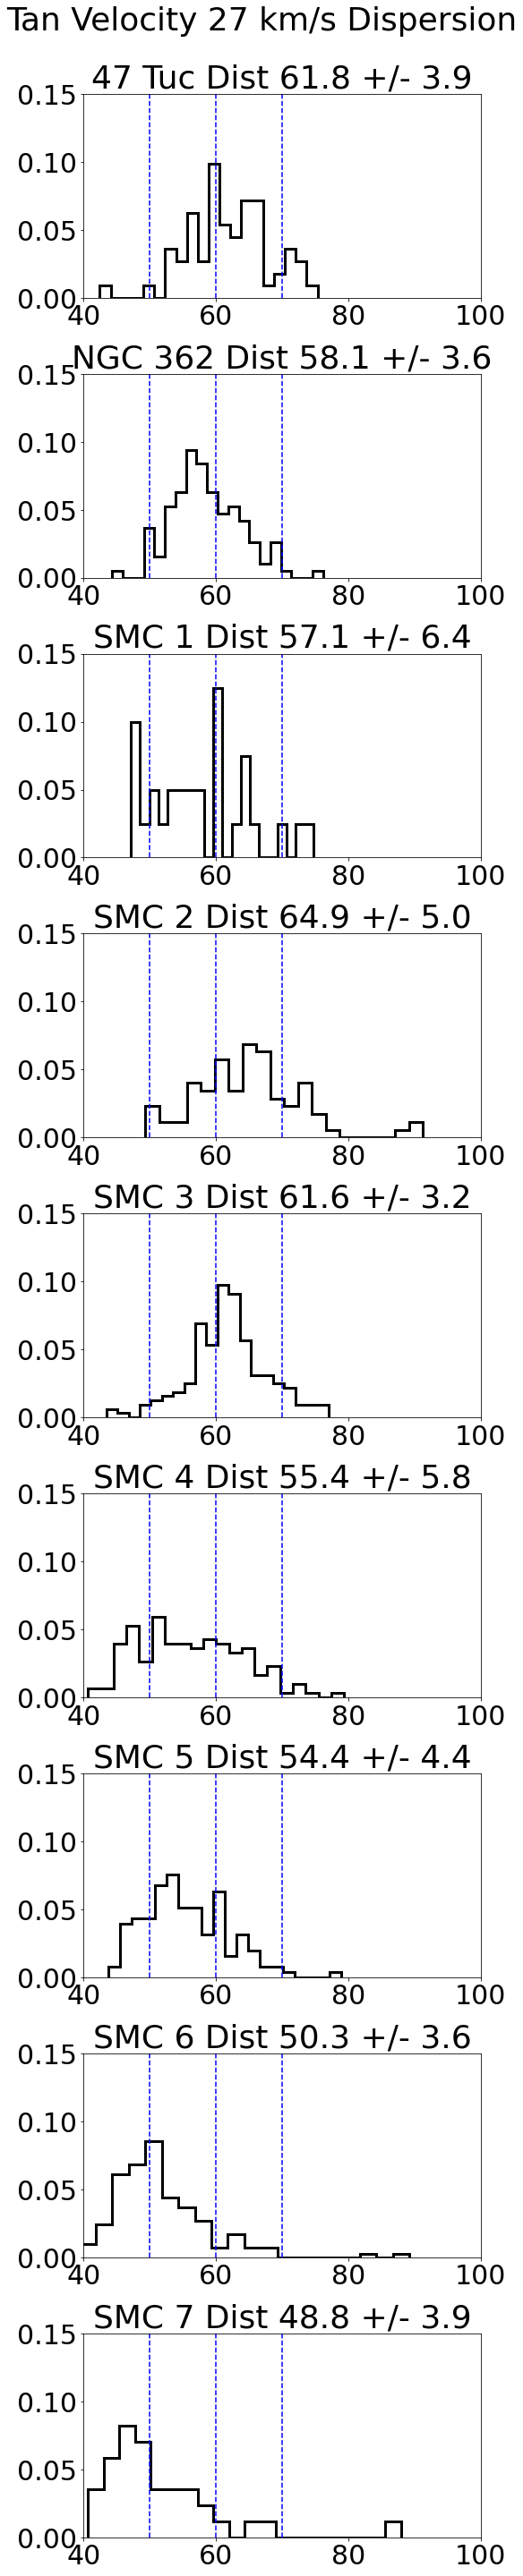

In [14]:
distance_dist = [np.median(tuc47_dist27,1),np.median(n362_dist27,1),np.median(smc1_dist27,1),
                 np.median(smc2_dist27,1),np.median(smc3_dist27,1),np.median(smc4_dist27,1),
                 np.median(smc5_dist27,1),np.median(smc6_dist27,1),np.median(smc7_dist27,1)]
distance_dist_disp = [util.mad(tuc47_dist27),util.mad(n362_dist27),util.mad(smc1_dist27),
                      util.mad(smc2_dist27),util.mad(smc3_dist27),util.mad(smc4_dist27),
                      util.mad(smc5_dist27),util.mad(smc6_dist27),util.mad(smc7_dist27)]
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(distance_dist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.15)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_dist[i]),
                                                        util.mad(distance_dist[i])))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle(r'Tan Velocity 27 km/s Dispersion',y=1.)
plt.tight_layout(pad=0.5)

plt.show()

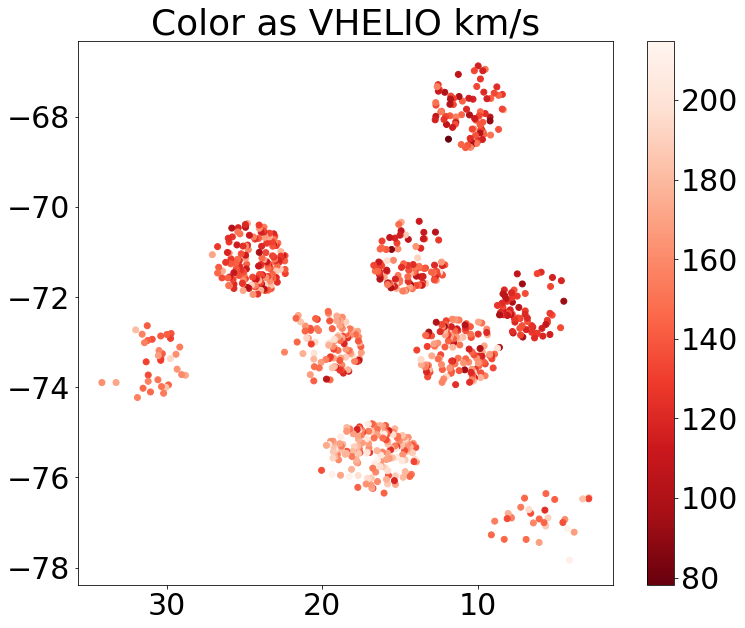

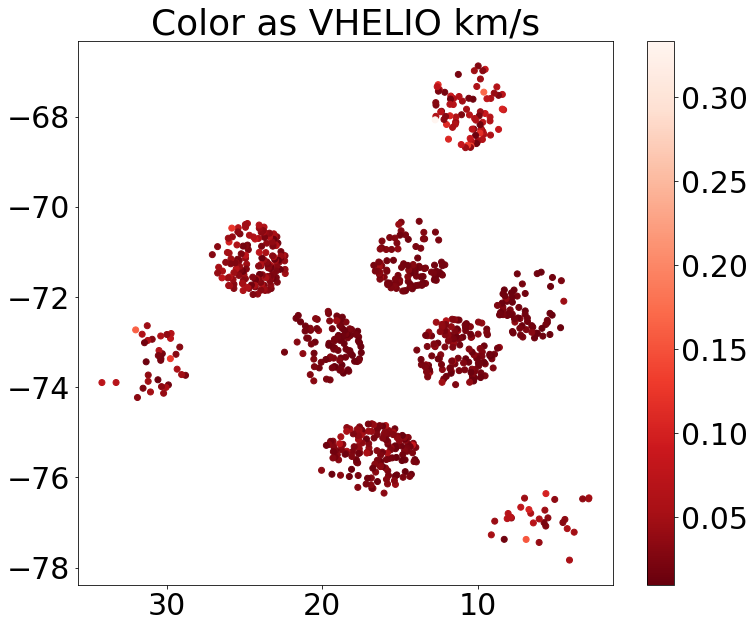

In [15]:
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],c=smc_nobloop['VHELIO_AVG'],cmap='Reds_r')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as VHELIO km/s')

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],c=smc_nobloop['VERR'],cmap='Reds_r')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as VHELIO km/s')

plt.show()

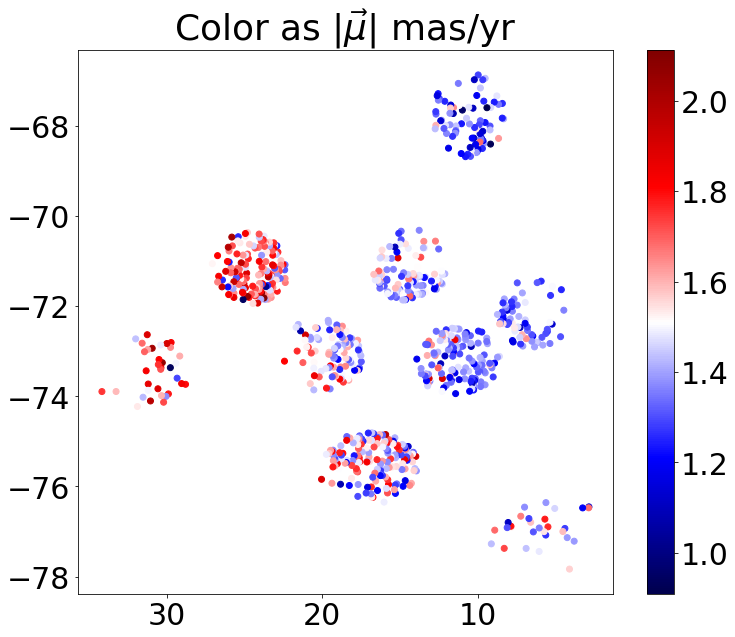

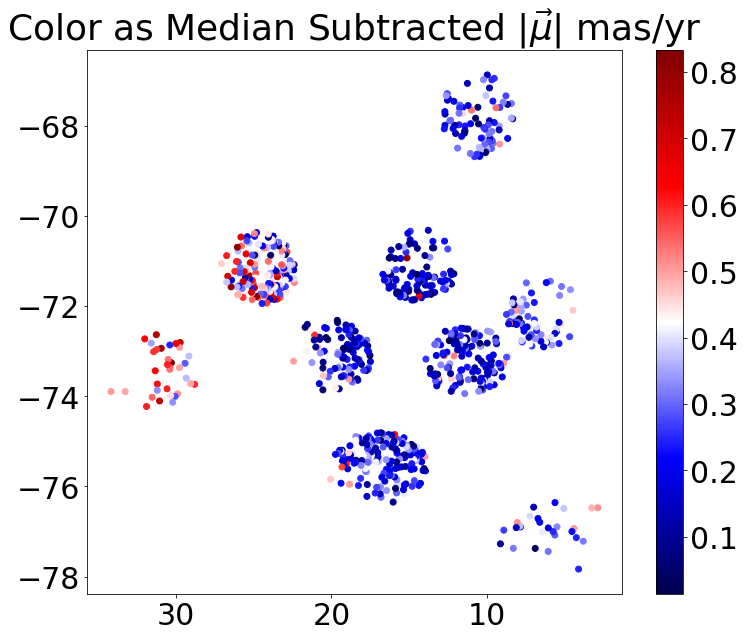

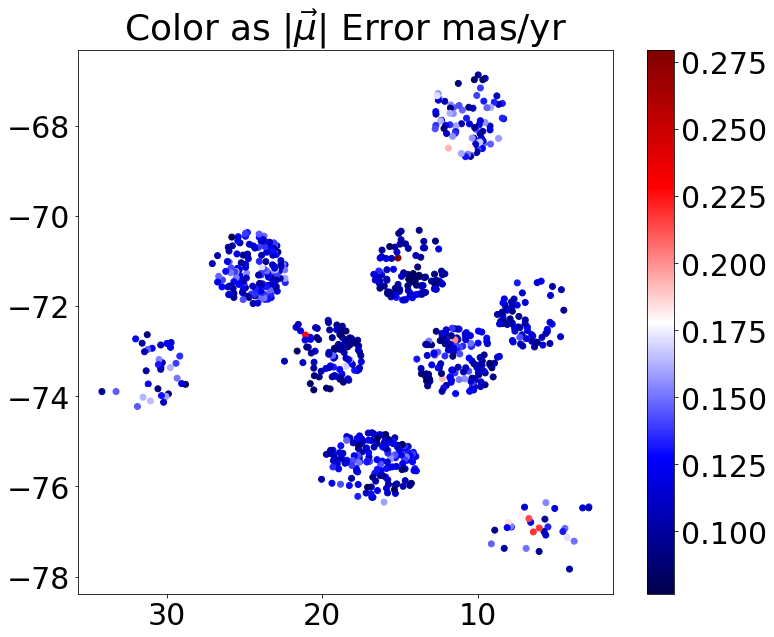

In [19]:
### Proper Motion Magnitude
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as $|\vec{\mu}|$ mas/yr')

plt.show()

### Median Subtracted
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt((smc_nobloop['GAIA_PMRA']-np.median(smc_nobloop['GAIA_PMRA']))**2+
                      (smc_nobloop['GAIA_PMDEC']-np.median(smc_nobloop['GAIA_PMDEC']))**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Median Subtracted $|\vec{\mu}|$ mas/yr')

plt.show()

### Error 
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA_ERROR']**2+smc_nobloop['GAIA_PMDEC_ERROR']**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as $|\vec{\mu}|$ Error mas/yr')

plt.show()

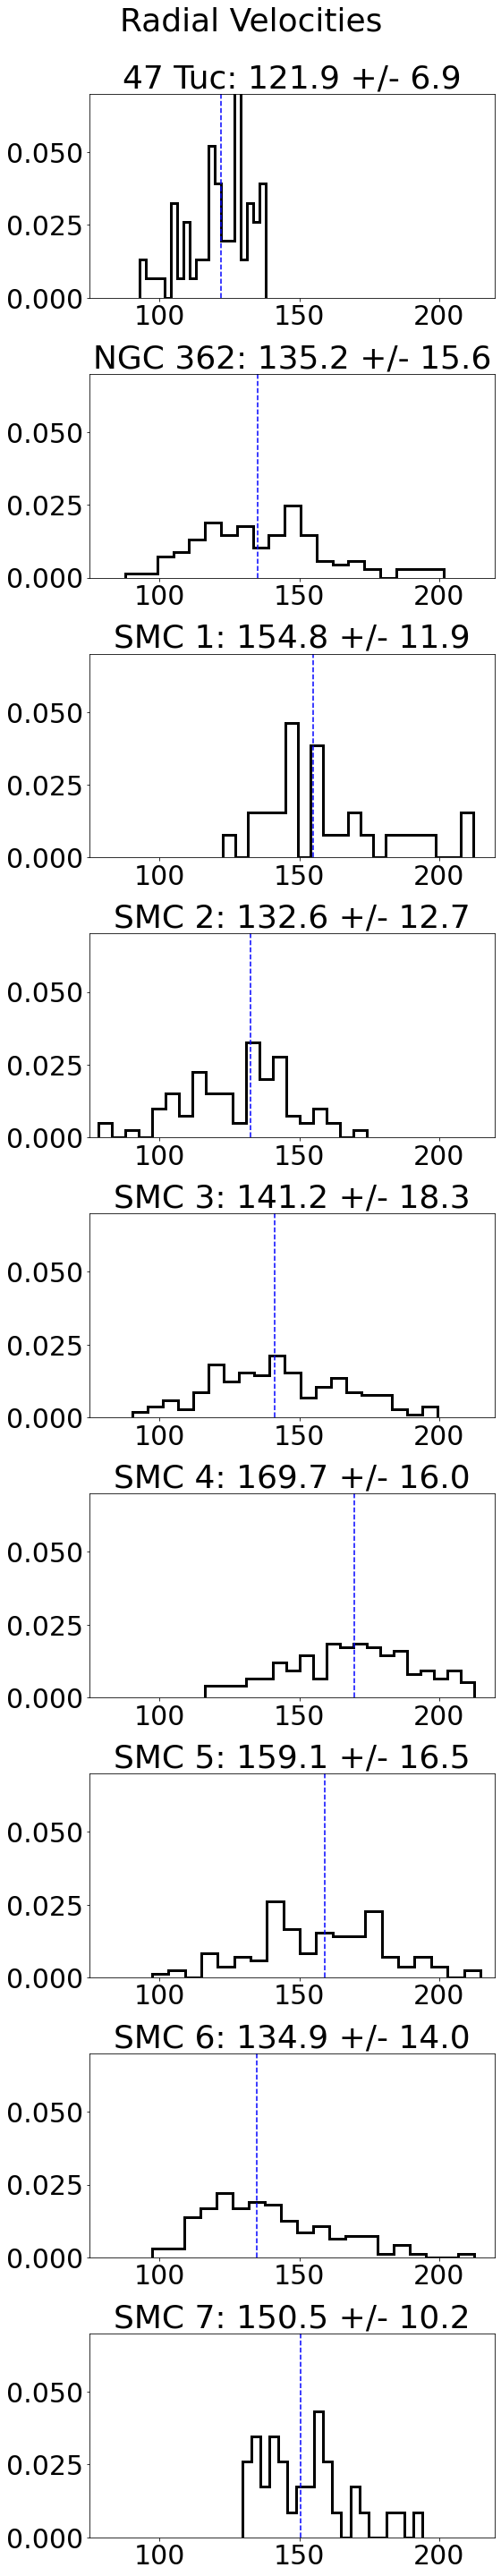

In [21]:
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(smc['VHELIO_AVG'][field_idx[i]],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
#     ax[i].legend()
    
    ax[i].set_ylim(top=0.07)
    ax[i].set_xlim(75,220)
    
    ax[i].set_title(r'{}: {:.1f} +/- {:.1f}'.format(distance_label[i],
                                                   np.median(smc['VHELIO_AVG'][field_idx[i]]),
                                                    util.mad(smc['VHELIO_AVG'][field_idx[i]])))
    
    ax[i].axvline(np.median(smc['VHELIO_AVG'][field_idx[i]]),ls='--',c='b')

plt.suptitle(r'Radial Velocities',y=1.0)
plt.tight_layout(pad=0.5)

plt.show()

<font size='45'>
    <b>
        Photometric Distances
    </b>
</font>

Assume that the overall median distance of all the red clump stars is 60 kpc away

In [28]:
#distance modulus of smc at 60 kpc
mod60 = 5*np.log10(60000)-5
print('60 kpc dm: ', mod60)

#calculate median absolute magnitude using 
med_abs = np.median(rc_gaia['phot_g_mean_mag'])-mod60
print('Expected Abs G of RC: ',med_abs)

#Field distances 
dist_phot47 = 10**((rc47['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot362 = 10**((rc362['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot1 = 10**((rc1['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot2 = 10**((rc2['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot3 = 10**((rc3['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot4 = 10**((rc4['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot5 = 10**((rc5['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot6 = 10**((rc6['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot7 = 10**((rc7['phot_g_mean_mag']-med_abs)/5.+1)/1000


60 kpc dm:  18.89075625191822
Expected Abs G of RC:  0.317350742710687


In [29]:
rcsubapogee = []
for i in range(len(rcs)):
    rcsubapogee.append(np.median(rcs[i]['phot_g_mean_mag'])-np.median(smc[field_idx[i]]['GAIA_GMAG']))

In [30]:
print(np.asarray(rcsubapogee))

[3.1016083 3.1153202 2.6386528 2.5965424 3.1650887 2.884182  3.247427
 2.6300583 2.5880852]


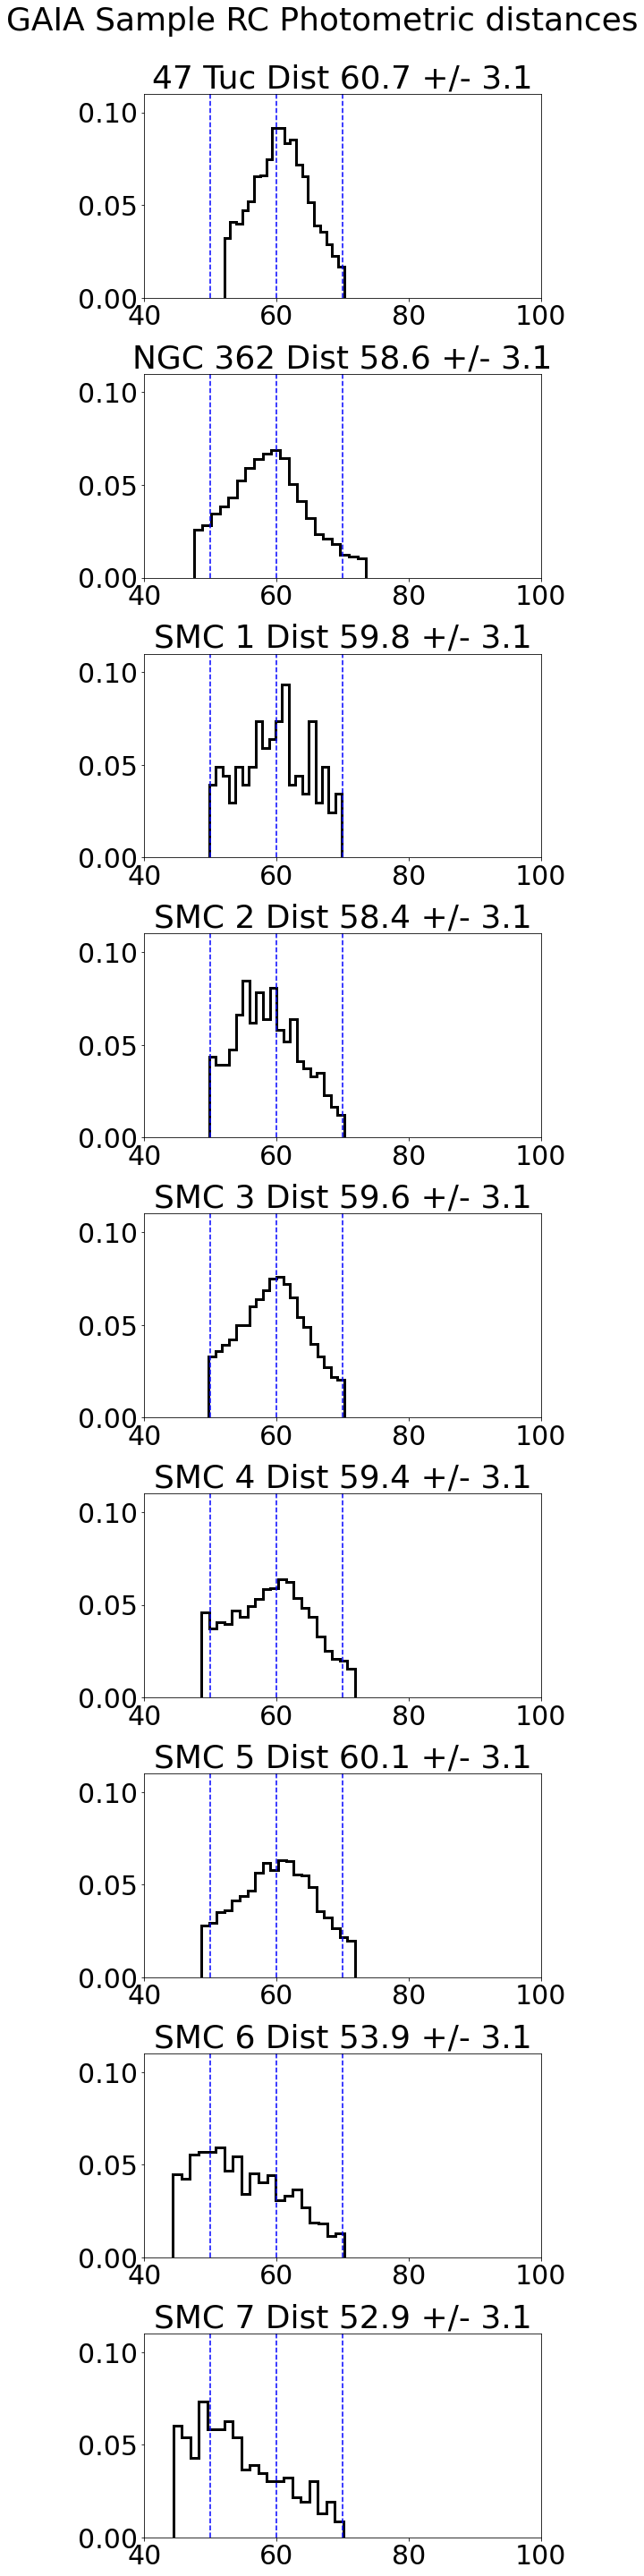

In [31]:
phot_dist = [dist_phot47,dist_phot362,dist_phot1,dist_phot2,dist_phot3,dist_phot4,dist_phot5,dist_phot6,
             dist_phot7]
phot_dist_disp = [util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47),
                      util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47),
                      util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47)]
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(phot_dist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.11)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(phot_dist[i]),
                                                        phot_dist_disp[i]))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle(r'GAIA Sample RC Photometric distances',y=1.)
plt.tight_layout(pad=0.5)

plt.show()

In [32]:
### phot distance using DR1 0.44 RC Abs Mag calibration 
dr1_dist = []
for i in [rc47['phot_g_mean_mag'],rc362['phot_g_mean_mag'],rc1['phot_g_mean_mag'],rc2['phot_g_mean_mag'],
          rc3['phot_g_mean_mag'],rc4['phot_g_mean_mag'],rc5['phot_g_mean_mag'],rc6['phot_g_mean_mag'],
          rc7['phot_g_mean_mag']]:
    dr1_dist.append(10**((np.asarray(i)-0.44)/5.+1))
    
dr1_meds = []
for j in range(len(dr1_dist)):
    dr1_meds.append(np.median(dr1_dist[j]))

### find offset such that the median rc phot distance is 60 kpc
offset = 60000 - np.median(dr1_meds)
dist_edr3_meds = dr1_meds+offset
# dist_edr3 = np.add(dr1_dist,offset)

In [33]:
offset

3867.7421875

In [34]:
dist_edr3_meds

array([61226.44 , 59261.723, 60367.617, 59052.773, 60168.227, 60000.   ,
       60644.227, 54804.605, 53892.652], dtype=float32)

<font size='45'>
    <b>
        Photo-Kinematic Distance
    </b>
</font>

Assumptions: 1) all stars in each field have essentially the same tangential motion 2) the overall median distance across the smc for the RC stars is at 60 kpc

In [35]:
tuc47_kpdist27 = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[0]/1000.*np.median(rc_mu_fields[0]),27,100)
    d = tanv/(4.74*mu)
    tuc47_kpdist27.append(d)
    
n362_kpdist27 = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[1]/1000.*np.median(rc_mu_fields[1]),27,100)
    d = tanv/(4.74*mu)
    n362_kpdist27.append(d)
    
smc1_kpdist27 = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[2]/1000.*np.median(rc_mu_fields[2]),27,100)
    d = tanv/(4.74*mu)
    smc1_kpdist27.append(d)
    
smc2_kpdist27 = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[3]/1000.*np.median(rc_mu_fields[3]),27,100)
    d = tanv/(4.74*mu)
    smc2_kpdist27.append(d)
    
smc3_kpdist27 = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[4]/1000.*np.median(rc_mu_fields[4]),27,100)
    d = tanv/(4.74*mu)
    smc3_kpdist27.append(d)
    
smc4_kpdist27 = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[5]/1000.*np.median(rc_mu_fields[5]),27,100)
    d = tanv/(4.74*mu)
    smc4_kpdist27.append(d)
    
smc5_kpdist27 = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[6]/1000.*np.median(rc_mu_fields[6]),27,100)
    d = tanv/(4.74*mu)
    smc5_kpdist27.append(d)
    
smc6_kpdist27 = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[7]/1000.*np.median(rc_mu_fields[7]),27,100)
    d = tanv/(4.74*mu)
    smc6_kpdist27.append(d)
    
smc7_kpdist27 = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[8]/1000.*np.median(rc_mu_fields[8]),27,100)
    d = tanv/(4.74*mu)
    smc7_kpdist27.append(d)

In [36]:
len(smc7_kpdist27)

36

In [37]:
len(np.squeeze(smc7_ind))

36

In [38]:
dist_edr3_meds[8]

53892.652

In [39]:
util.mad(tuc47_kpdist27[0])

3.2157054734589536

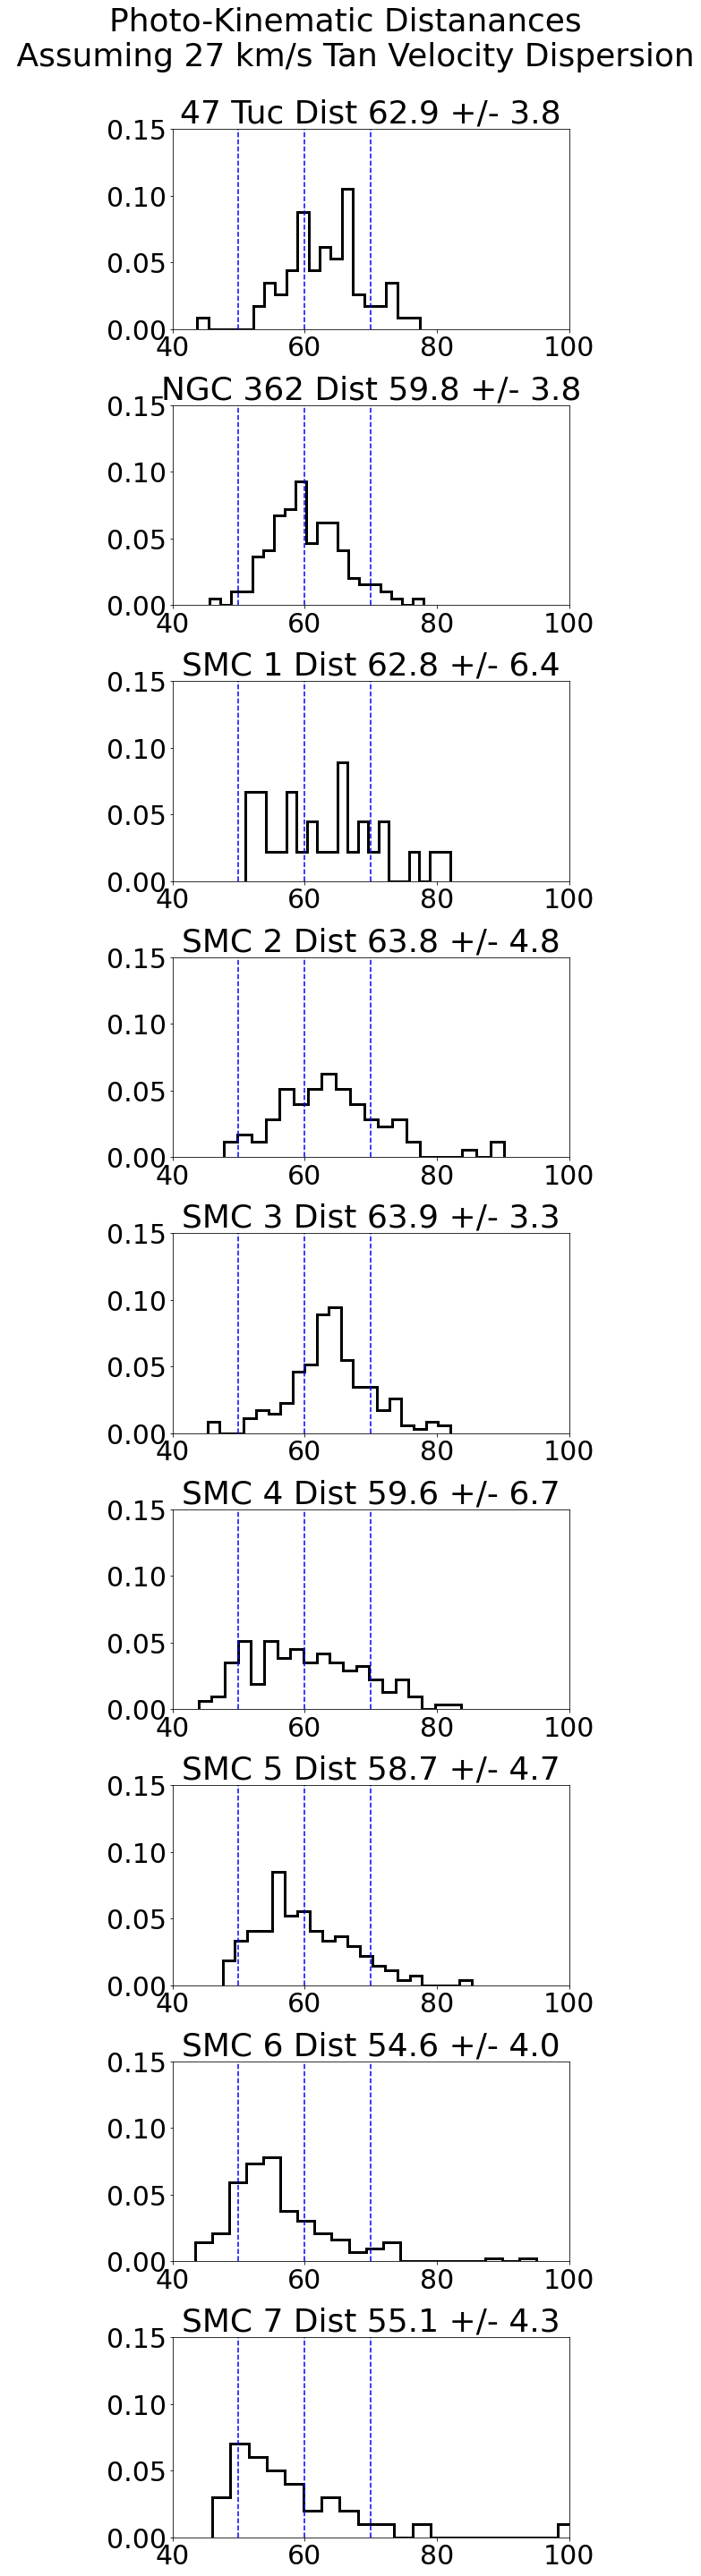

In [76]:
distance_kpdist = [np.median(tuc47_kpdist27,1),np.median(n362_kpdist27,1),np.median(smc1_kpdist27,1),
                 np.median(smc2_kpdist27,1),np.median(smc3_kpdist27,1),np.median(smc4_kpdist27,1),
                 np.median(smc5_kpdist27,1),np.median(smc6_kpdist27,1),np.median(smc7_kpdist27,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdist27),util.mad(n362_kpdist27),util.mad(smc1_kpdist27),
                      util.mad(smc2_kpdist27),util.mad(smc3_kpdist27),util.mad(smc4_kpdist27),
                      util.mad(smc5_kpdist27),util.mad(smc6_kpdist27),util.mad(smc7_kpdist27)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.15)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle('Photo-Kinematic Distanances \n Assuming 27 km/s Tan Velocity Dispersion',y=1.)
plt.tight_layout(pad=0.5)

plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

In [77]:
pwd

'/Users/joshuapovick/Desktop/Research/SMC_Gradients/SMC_Distances'

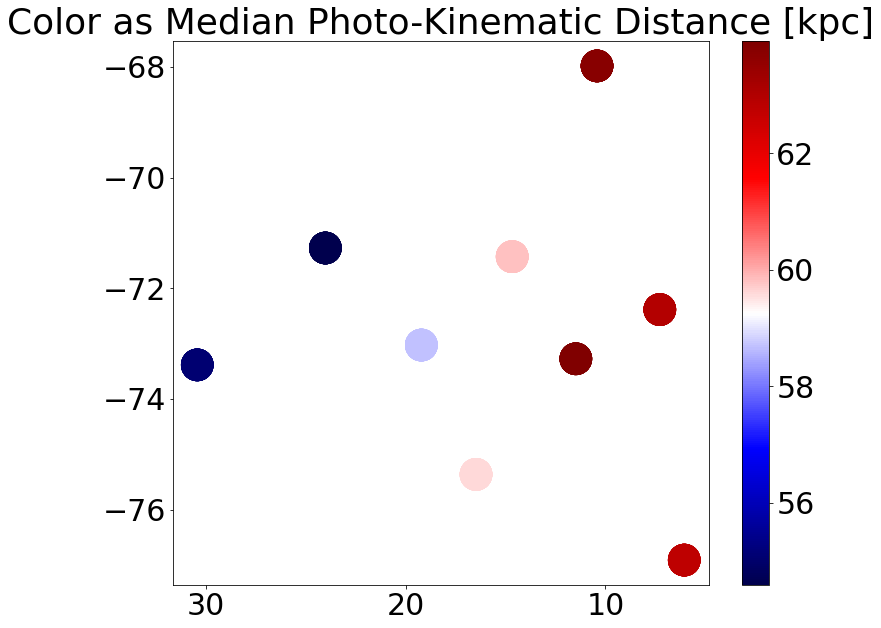

In [41]:
ra = []
dec = []
kpmed = []
kpmed_disp = []
for i in range(len(field_idx)):
    ra.append(np.median(smc[field_idx[i]]['RA']))
    dec.append(np.median(smc[field_idx[i]]['DEC']))
    kpmed.append(np.median(distance_kpdist[i]))
    kpmed_disp.append(util.mad(distance_kpdist[i]))
    

ra = np.asarray(ra)
dec = np.asarray(dec)
# radius = 0.95*np.ones(len(field))

plt.figure(figsize=[12,10])
for j in range(len(field_idx)):
    plt.scatter(ra,dec,c=kpmed,cmap='seismic',s=1000,vmax=max(kpmed),vmin=min(kpmed))
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Median Photo-Kinematic Distance [kpc]')

plt.show()

In [42]:
### 47 Tuc
smc47field = []
smc47mads = []
for i in range(len(np.squeeze(tuc47_ind))):
    smc47field.append('47TUC')
    smc47mads.append(util.mad(tuc47_kpdist27[i]))

tsmc47 = Table()
col_id = Column(np.asarray(smc[tuc47_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc47field),name='FIELD')
col_distance = Column(np.median(tuc47_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc47mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(tuc47_kpdist27),name='DISTANCE_DIST')

tsmc47.add_column(col_id)
tsmc47.add_column(col_field)
tsmc47.add_column(col_distance)
tsmc47.add_column(col_dev)
tsmc47.add_column(col_dist)

### NGC 362
smc362field = []
smc362mads = []
for i in range(len(np.squeeze(n362_ind))):
    smc362field.append('N362')
    smc362mads.append(util.mad(n362_kpdist27[i]))

tsmc362 = Table()
col_id = Column(np.asarray(smc[n362_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc362field),name='FIELD')
col_distance = Column(np.median(n362_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc362mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(n362_kpdist27),name='DISTANCE_DIST')

tsmc362.add_column(col_id)
tsmc362.add_column(col_field)
tsmc362.add_column(col_distance)
tsmc362.add_column(col_dev)
tsmc362.add_column(col_dist)

### SMC 1
smc1field = []
smc1mads = []
for i in range(len(np.squeeze(smc1_ind))):
    smc1field.append('SMC1')
    smc1mads.append(util.mad(smc1_kpdist27[i]))

tsmc1 = Table()
col_id = Column(np.asarray(smc[smc1_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc1field),name='FIELD')
col_distance = Column(np.median(smc1_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc1mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc1_kpdist27),name='DISTANCE_DIST')

tsmc1.add_column(col_id)
tsmc1.add_column(col_field)
tsmc1.add_column(col_distance)
tsmc1.add_column(col_dev)
tsmc1.add_column(col_dist)

### SMC 2
smc2field = []
smc2mads = []
for i in range(len(np.squeeze(smc2_ind))):
    smc2field.append('SMC2')
    smc2mads.append(util.mad(smc2_kpdist27[i]))

tsmc2 = Table()
col_id = Column(np.asarray(smc[smc2_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc2field),name='FIELD')
col_distance = Column(np.median(smc2_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc2mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc2_kpdist27),name='DISTANCE_DIST')

tsmc2.add_column(col_id)
tsmc2.add_column(col_field)
tsmc2.add_column(col_distance)
tsmc2.add_column(col_dev)
tsmc2.add_column(col_dist)

### SMC 3
smc3field = []
smc3mads = []
for i in range(len(np.squeeze(smc3_ind))):
    smc3field.append('SMC3')
    smc3mads.append(util.mad(smc3_kpdist27[i]))
    
tsmc3 = Table()
col_id = Column(np.asarray(smc[smc3_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc3field),name='FIELD')
col_distance = Column(np.median(smc3_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc3mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc3_kpdist27),name='DISTANCE_DIST')

tsmc3.add_column(col_id)
tsmc3.add_column(col_field)
tsmc3.add_column(col_distance)
tsmc3.add_column(col_dev)
tsmc3.add_column(col_dist)

### SMC 4
smc4field = []
smc4mads = []
for i in range(len(np.squeeze(smc4_ind))):
    smc4field.append('SMC4')
    smc4mads.append(util.mad(smc4_kpdist27[i]))
    
tsmc4 = Table()
col_id = Column(np.asarray(smc[smc4_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc4field),name='FIELD')
col_distance = Column(np.median(smc4_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc4mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc4_kpdist27),name='DISTANCE_DIST')

tsmc4.add_column(col_id)
tsmc4.add_column(col_field)
tsmc4.add_column(col_distance)
tsmc4.add_column(col_dev)
tsmc4.add_column(col_dist)

### SMC 5
smc5field = []
smc5mads = []
for i in range(len(np.squeeze(smc5_ind))):
    smc5field.append('SMC5')
    smc5mads.append(util.mad(smc5_kpdist27[i]))

tsmc5 = Table()
col_id = Column(np.asarray(smc[smc5_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc5field),name='FIELD')
col_distance = Column(np.median(smc5_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc5mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc5_kpdist27),name='DISTANCE_DIST')

tsmc5.add_column(col_id)
tsmc5.add_column(col_field)
tsmc5.add_column(col_distance)
tsmc5.add_column(col_dev)
tsmc5.add_column(col_dist)

### SMC 6
smc6field = []
smc6mads = []
for i in range(len(np.squeeze(smc6_ind))):
    smc6field.append('SMC6')
    smc6mads.append(util.mad(smc6_kpdist27[i]))

tsmc6 = Table()
col_id = Column(np.asarray(smc[smc6_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc6field),name='FIELD')
col_distance = Column(np.median(smc6_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc6mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc6_kpdist27),name='DISTANCE_DIST')

tsmc6.add_column(col_id)
tsmc6.add_column(col_field)
tsmc6.add_column(col_distance)
tsmc6.add_column(col_dev)
tsmc6.add_column(col_dist)

### SMC 7
smc7field = []
smc7mads = []
for i in range(len(np.squeeze(smc7_ind))):
    smc7field.append('SMC7')
    smc7mads.append(util.mad(smc7_kpdist27[i]))

tsmc7 = Table()
col_id = Column(np.asarray(smc[smc7_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc7field),name='FIELD')
col_distance = Column(np.median(smc7_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc7mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc7_kpdist27),name='DISTANCE_DIST')

tsmc7.add_column(col_id)
tsmc7.add_column(col_field)
tsmc7.add_column(col_distance)
tsmc7.add_column(col_dev)
tsmc7.add_column(col_dist)

### order matches original smc file 
distance_table = vstack([tsmc3,tsmc362,tsmc5,tsmc47,tsmc4,tsmc6,tsmc1,tsmc2,tsmc7])

distance_table.write('smc_photokinematic_distances.fits',format='fits')#,overwrite=True)

In [45]:
calc_distance = fits.getdata('smc_photokinematic_distances.fits',0)
calc_distance.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'FIELD'; format = '5A'
    name = 'DISTANCE'; format = 'D'
    name = 'DISTANCE_ERR'; format = 'D'
    name = 'DISTANCE_DIST'; format = '100D'; dim = '(100)'
)

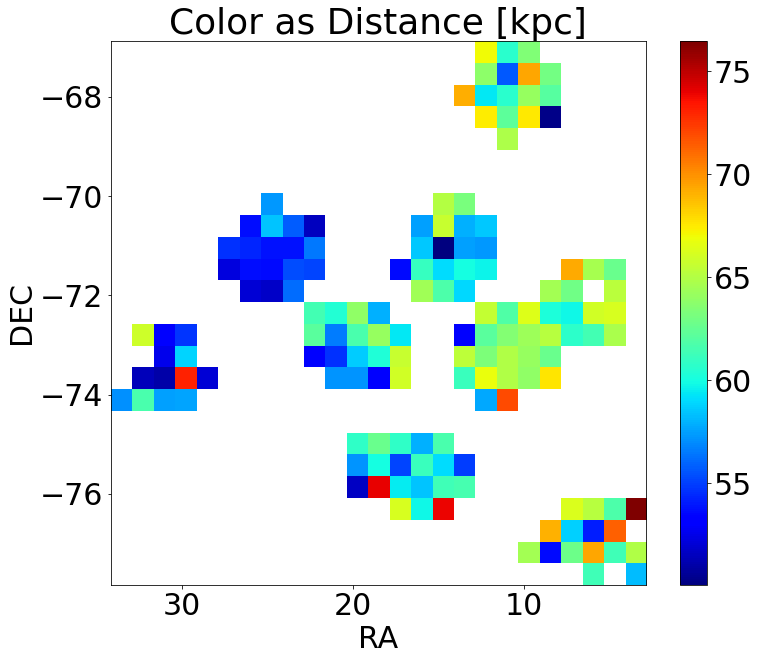

In [69]:
distmed = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance['DISTANCE'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(distmed.statistic.T, origin='lower',
           extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map.pdf',bbox_inches='tight')
plt.show()